In [ ]:
# -- install required packages
#%pip install scikit-gstat
#%pip install pytest
#%pip install matplotlib-scalebar

In [15]:
import os
import sys
import pandas as pd
import numpy as np
import skgstat as skg
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.interpolate import NearestNDInterpolator

sys.path.append('/Users/ninakilham/Documents/GitHub/kobold-takehome/src')
import utils as kutils

plt.style.use('ggplot')
skg.plotting.backend('matplotlib')

### Soil geochemistry take-home
_author: Nina Kilham_

April 21, 2025

**Background:** The objective is to infer and plot a continuous spatial distribution of trace metal concentrations for an entire area from a set of soil samples taken in the field. The two metals measured are of copper (Cu) and/or Cobalt (Co) given in parts-per-million at several sample locations. 

In [3]:
# -- get the sample point
filepath = '/Users/ninakilham/Documents/GitHub/kobold-takehome/data/soil_geochemistry.csv'
df = pd.read_csv(filepath)

In [4]:
# -- look at the file contents
df.head()

,Cu,Co,x,y,units
0,1005.545921,282.993340,99.901372,14.761337,ppm
1,867.986487,234.174761,55.263516,1.302959,ppm
2,96.807653,NaN,65.098168,85.424006,ppm
3,2.551491,0.346934,3.332742,72.062110,ppm
4,2374.160259,NaN,85.222209,25.060859,ppm


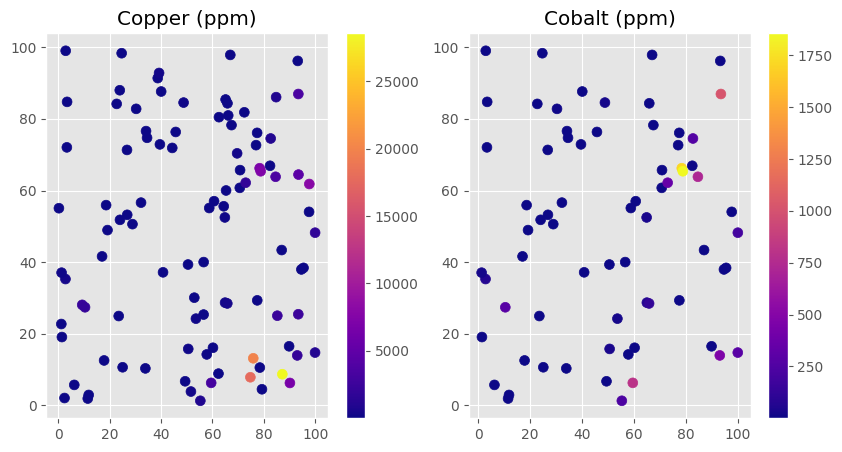

In [6]:
# -- plot an overview of each element
fig, ax = plt.subplots(1,2, figsize=(10, 5))
plot_overview(df, 'Cu', 'Copper (ppm)', ax[0])
plot_overview(df, 'Co', 'Cobalt (ppm)', ax[1])

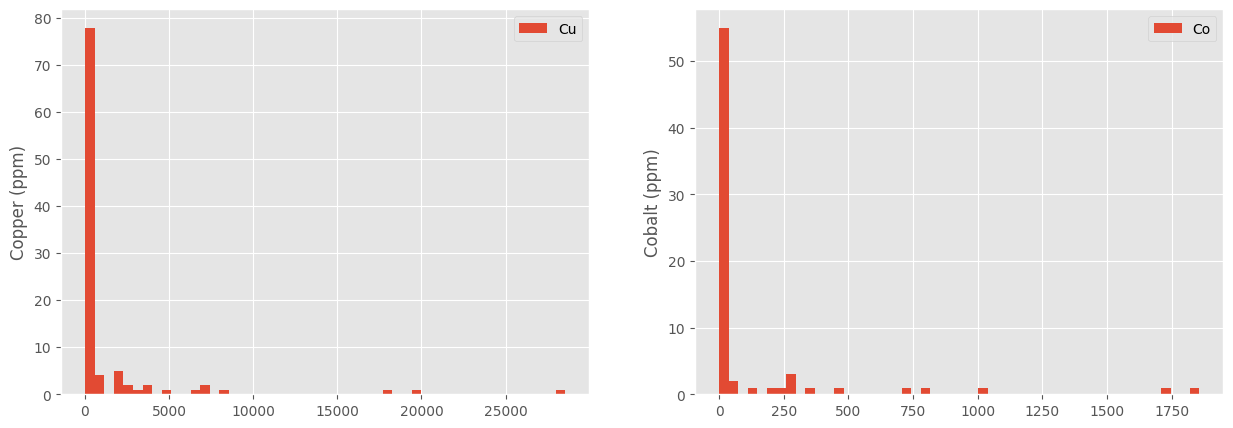

In [8]:
# -- look at the distributions
fig, ax = plt.subplots(1,2, figsize=(15, 5))
plot_hist(df, 'Cu', 'Copper (ppm)', ax[0])
plot_hist(df, 'Co', 'Cobalt (ppm)', ax[1])

In [9]:
# -- check for no data values and split dataframe
co = df.copy().drop('Cu', axis=1)
cu = df.copy().drop('Co', axis=1)

### Variogram

From the plots, it looks like there are a couple of hotspots, and several locations with very low values. We are interested in how the values vary by location, so that we may predict the distribution of the full field. We can model this using a variogram relating pair-wise distances of the coordinates to the semi-variance of the corresponding value pairs.

In [ ]:
# -- Start with copper
V = skg.Variogram(df[['x', 'y']].values, df['Cu'].values, n_lags=15, normalize=False
                  )
fig = V.plot(show=False)

We can see that the first bins are not well-captured, so adding a nugget may be necessary. Also, the default spherical model doesn't capture the shape very well.

In [ ]:
# cycle through the possible models to see which fits best, and using scotts rule to select the bins
V.bin_func = 'scott'
fig, _a = plt.subplots(2,3, figsize=(12, 6), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    V.model = model
    V.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title('Model: %s; RMSE: %.2f' % (model, V.rmse))
    
plt.tight_layout()

Of these, the matern model performs best, although the fit to the first and last bins is still poor. Let us see how this looks.

In [ ]:
V.model = 'matern'
ok = skg.OrdinaryKriging(V, min_points=5, max_points=15, mode='exact')

# build the target grid
x = df.x.values
y = df.y.values
vals = df.Cu.values
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)


In [ ]:
# -- plot the result
fig, axes = plt.subplots(1,2, figsize=(10,5))

# rescale the coordinates to fit the interpolation raster
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

cmp1 = axes[0].matshow(field.T, origin='lower', cmap='plasma', vmin=vals.min(), vmax=vals.max())
axes[0].set_title('Copper Concentrations (ppm)')
axes[0].plot(x_, y_, '+w')
axes[0].set_xlim((0, 100))
axes[0].set_ylim((0, 100))
plt.colorbar(cmap1, ax=axes[0])

art = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error')
plt.colorbar(art, ax=axes[1], format="%.1f")
axes[1].plot(x_, y_, '+w')
axes[1].set_xlim((0, 100))
axes[1].set_ylim((0, 100))

scalebar = ScaleBar(0.2, units="m") 
axes[0].add_artist(scalebar)

plt.tight_layout()
fileout = os.path.join(os.path.dirname(filepath), 'copper_interpolated_map_with_error.png')
plt.savefig(fileout)

We can see that the hotspot location is captured reasonably, with greater errors away from the sample location. We could mask out the high error areas if desired. 

### Cobalt

Let's start with looking at all possible models to find the best fit. Recall that some sample locations do not have values for Cobalt, so we will want to drop these first.

In [ ]:
cobalt = df.copy().dropna()
print(f'There are {cobalt.shape[0]} valid Cobalt samples to use for interpolation')

In [ ]:
V = skg.Variogram(cobalt[['x', 'y']].values, cobalt['Co'].values, n_lags=15, normalize=False)
V.bin_func = 'scott'
fig, _a = plt.subplots(2,2, figsize=(12, 6), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern')):
    V.model = model
    V.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title('Model: %s; RMSE: %.2f' % (model, V.rmse))
    
plt.tight_layout()

None of the models are performing very well, and there is no apparent spatial dependency. So let us just try a simple nearest neighbors interpolation.

In [ ]:
# build the target grid
x = cobalt.x.values
y = cobalt.y.values
vals = cobalt.Cu.values
X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))
xx, yy = np.meshgrid(X, Y)

In [ ]:
# -- do the interpolation
interp = NearestNDInterpolator(list(zip(x, y)), vals)
Z = interp(xx,yy)

In [ ]:
plt.pcolormesh(xx,yy, Z, shading='auto')
plt.plot(x, y, "w+")
plt.colorbar()
plt.axis("equal")
plt.title('Cobalt Concentrations (ppm)')
plt.show()
fileout = os.path.join(os.path.dirname(filepath), 'cobalt_nninterpolated_map.png')
plt.savefig(fileout)

Althoug simple, this does capture the hot spot and the apparent distribution with the limited samples of Cobalt.